In [1]:
%load_ext lab_black

from ctypes import CDLL, Structure, c_int, c_uint16, c_uint32, c_bool, POINTER
from scipy import signal
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
import ctypes
import matplotlib.pyplot as plt
import numpy as np
import os
import serial
import time

Se carga el archivo de audio

In [2]:
base_path = "/tf/notebooks/CEIA/ia-embebida/noise-gate"
assets_path = os.path.join(base_path, "assets")
audios_path = os.path.join(assets_path, "audios")
labels_path = os.path.join(assets_path, "labels")

samplerate, data = wavfile.read(os.path.join(audios_path, "recording_01.wav"))

data_len = len(data)
duration = data_len / samplerate
print(f"Cantidad de muestras: {data_len}")
print(f"Frecuencia de muestreo: {samplerate} Hz")
print(f"Duracion: {duration:.1f} segundos")
print(f"Valor maximo: {max(data)}")
print(f"Valor minimo: {min(data)}")
print(f"Tipo de dato: {type(data[0])}")

Cantidad de muestras: 956007
Frecuencia de muestreo: 22050 Hz
Duracion: 43.4 segundos
Valor maximo: 32767
Valor minimo: -32768
Tipo de dato: <class 'numpy.int16'>


/tmp/ipykernel_69/2236063515.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(os.path.join(audios_path, "recording_01.wav"))


Graficamos la señal y su fft

In [3]:
timeline = np.linspace(0, duration, num=data_len)

x_freq = fftfreq(data_len, 1 / samplerate)[: data_len // 2]
data_fft = np.abs(fft(data)[0 : data_len // 2])

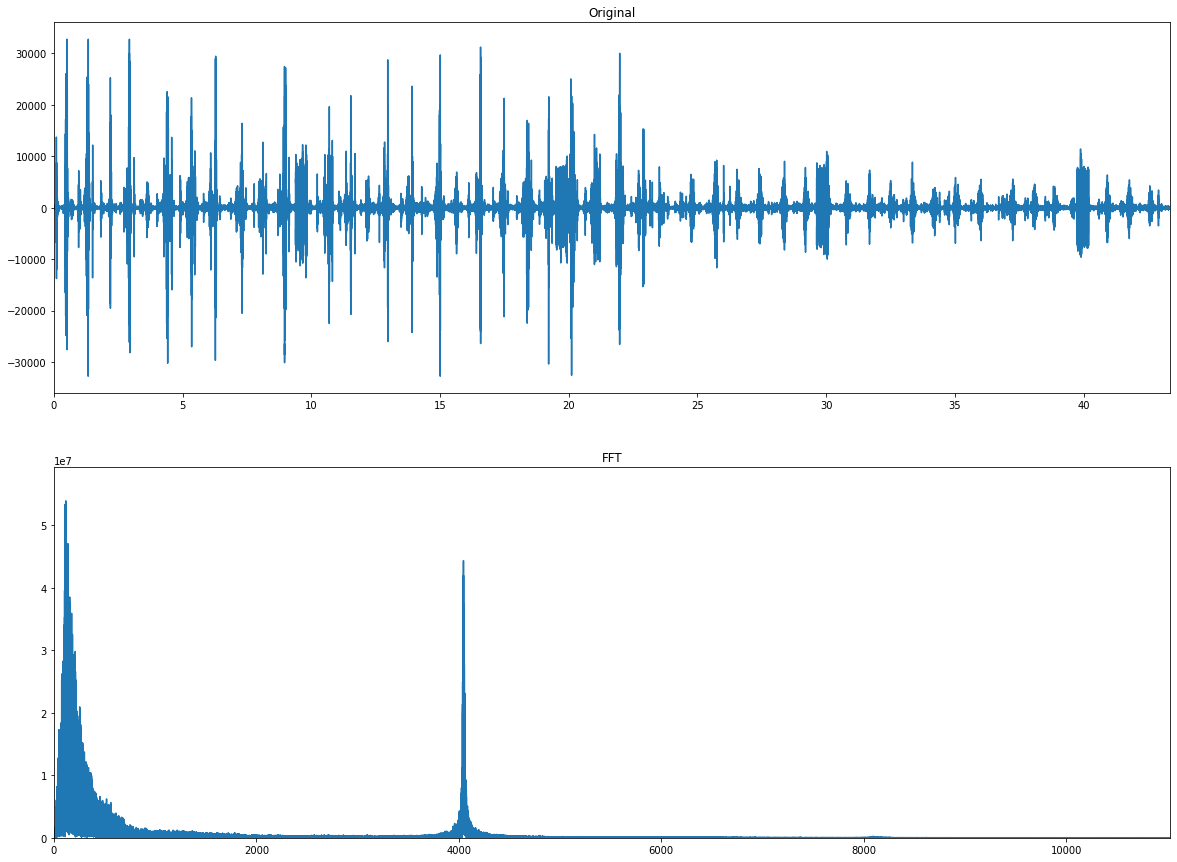

In [4]:
f, axes = plt.subplots(2, figsize=(20, 15))

axes[0].plot(timeline, data)
axes[0].set_xlim([0, duration])
axes[0].set_title("Original")

axes[1].plot(x_freq, data_fft)
axes[1].set_xlim([0, x_freq[-1]])
axes[1].set_ylim([0, max(data_fft) * 1.1])
axes[1].set_title("FFT")

f.show()

Diseñamos un filtro pasa bajo con una banda de paso de hasta 2000Hz y lo aplicamos a nuestra señal

In [5]:
filter_order, wn = signal.buttord(
    wp=2000, ws=3000, gpass=3, gstop=40, analog=False, fs=samplerate
)
b, a = signal.butter(filter_order, wn, "lowpass", analog=False, fs=samplerate)

In [6]:
filtered_data = signal.lfilter(b, a, data)
filtered_data_fft = np.abs(fft(filtered_data)[0 : data_len // 2])

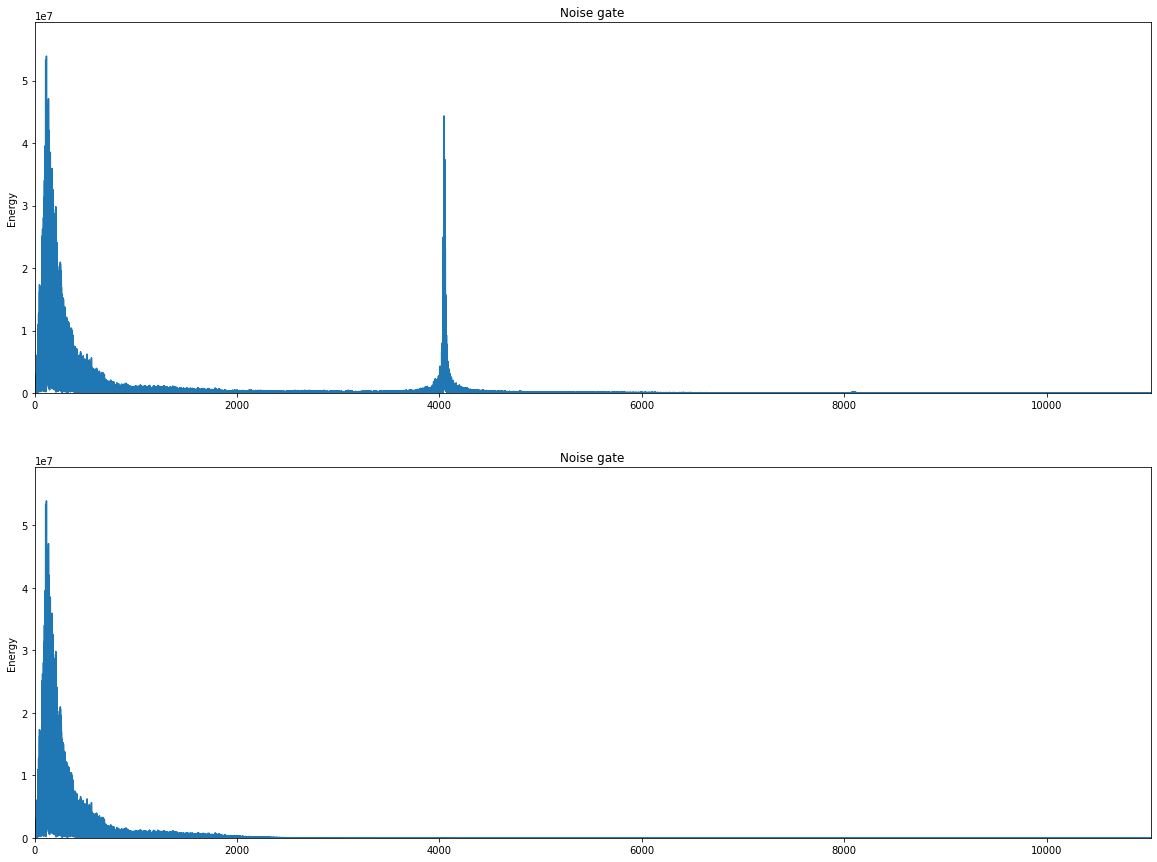

In [7]:
f, axes = plt.subplots(2, figsize=(20, 15))

axes[0].plot(x_freq, data_fft)
axes[0].set_xlim([0, x_freq[-1]])
axes[0].set_ylim([0, max(data_fft) * 1.1])
axes[0].set_title("Noise gate")
axes[0].set_ylabel("Energy")

axes[1].plot(x_freq, filtered_data_fft)
axes[1].set_xlim([0, x_freq[-1]])
axes[1].set_ylim([0, max(data_fft) * 1.1])
axes[1].set_title("Noise gate")
axes[1].set_ylabel("Energy")

f.show()

Hacemos la decimación y reducimos la frecuencia de muestreo 10 veces, es decir a 2.2KHz

In [8]:
dec_data = filtered_data[::10]
dec_timeline = timeline[::10]

dec_samplerate = samplerate / 10
dec_data_len = len(dec_data)
dec_data_fft = np.abs(fft(dec_data)[0 : dec_data_len // 2])
dec_x_freq = fftfreq(dec_data_len, 1 / dec_samplerate)[: dec_data_len // 2]

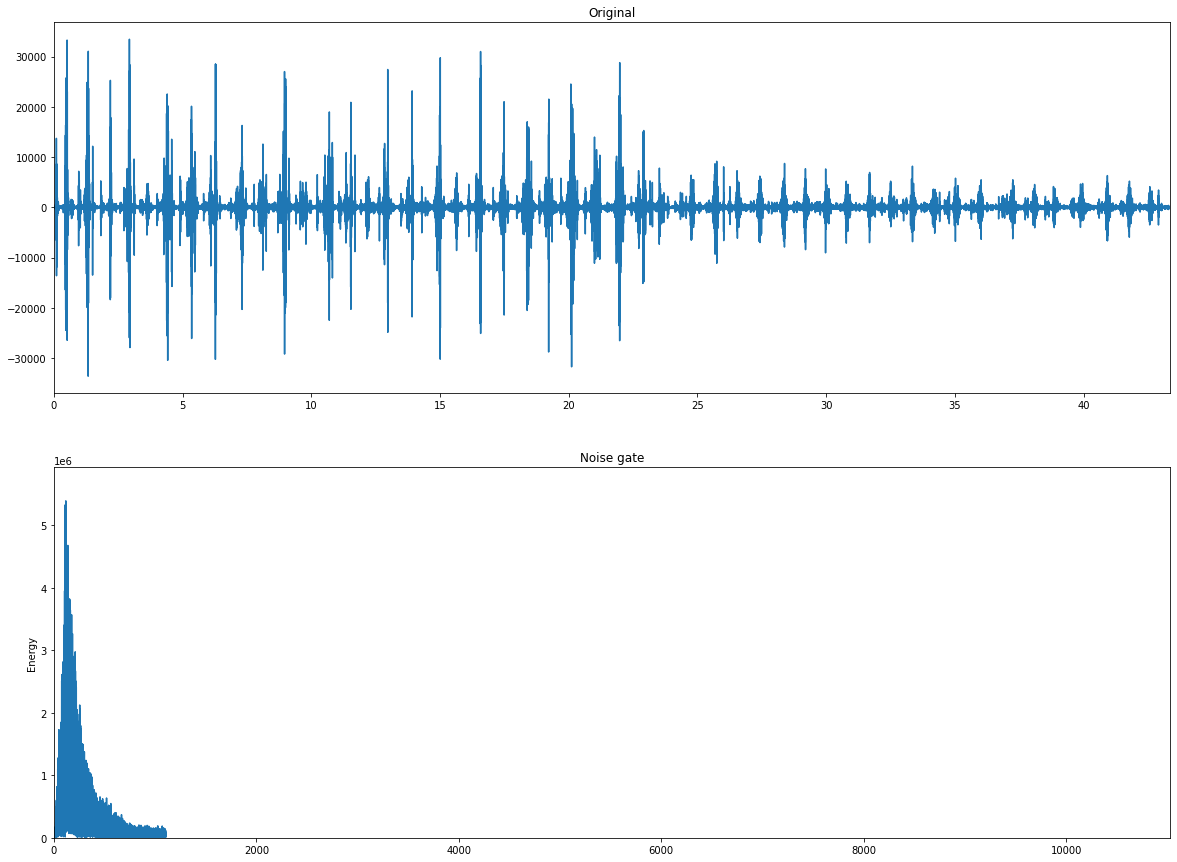

In [9]:
f, axes = plt.subplots(2, figsize=(20, 15))

axes[0].plot(dec_timeline, dec_data)
axes[0].set_xlim([0, duration])
axes[0].set_title("Original")

axes[1].plot(dec_x_freq, dec_data_fft)
axes[1].set_xlim([0, x_freq[-1]])
axes[1].set_ylim([0, max(dec_data_fft) * 1.1])
axes[1].set_title("Noise gate")
axes[1].set_ylabel("Energy")

f.show()

Elevamos los valores al cuadrado y aplicamos el filtro de promedio móvil

In [10]:
squared_data = dec_data**2

filter_order, wn = signal.buttord(
    wp=50, ws=150, gpass=3, gstop=20, analog=False, fs=dec_samplerate
)
# filter_order, wn = signal.buttord(
#     wp=50, ws=70, gpass=3, gstop=20, analog=False, fs=dec_samplerate
# )
b, a = signal.butter(filter_order, wn, "lowpass", analog=False, fs=dec_samplerate)

filtered_data_2 = signal.lfilter(b, a, squared_data)
filtered_data_fft_2 = np.abs(fft(filtered_data_2)[0 : dec_data_len // 2])

In [11]:
b, a

(array([0.00031579, 0.00094736, 0.00094736, 0.00031579]),
 array([ 1.        , -2.71506105,  2.46928626, -0.75169892]))

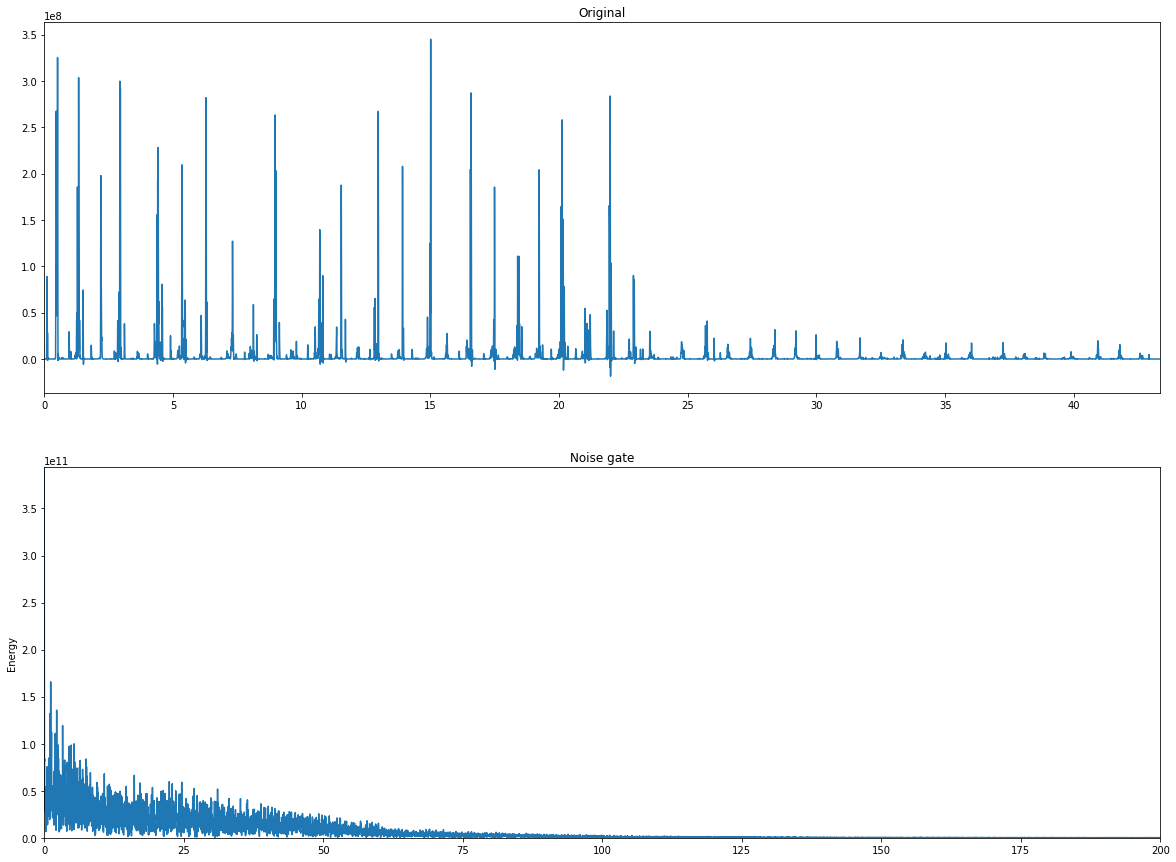

In [12]:
f, axes = plt.subplots(2, figsize=(20, 15))

axes[0].plot(dec_timeline, filtered_data_2)
axes[0].set_xlim([0, duration])
axes[0].set_title("Original")

axes[1].plot(dec_x_freq, filtered_data_fft_2)
axes[1].set_xlim([0, 200])
axes[1].set_ylim([0, max(filtered_data_fft_2)])
axes[1].set_title("Noise gate")
axes[1].set_ylabel("Energy")

f.show()

Vemos que la señal filtrada produce algunos valores negativos, como este filtro se implementará en el micro no deseamos tener valores negativos. Probamos eliminar la parte negativa de la señal, sabiendo que esto probablemente agregue ruido de alta frecuencia

In [13]:
filtered_data_3 = np.maximum(filtered_data_2, 0)
filtered_data_fft_3 = np.abs(fft(filtered_data_3)[0 : dec_data_len // 2])

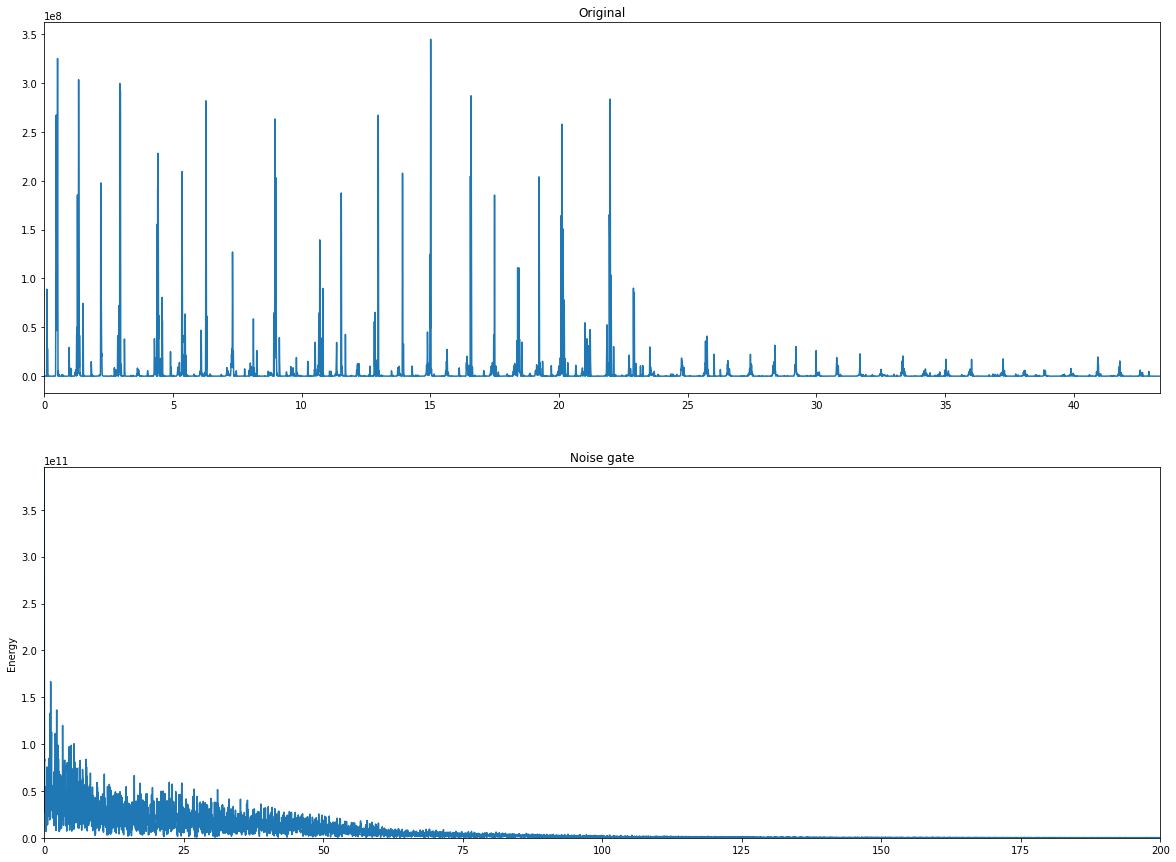

In [14]:
f, axes = plt.subplots(2, figsize=(20, 15))

axes[0].plot(dec_timeline, filtered_data_3)
axes[0].set_xlim([0, duration])
axes[0].set_title("Original")

axes[1].plot(dec_x_freq, filtered_data_fft_3)
axes[1].set_xlim([0, 200])
axes[1].set_ylim([0, max(filtered_data_fft_3)])
axes[1].set_title("Noise gate")
axes[1].set_ylabel("Energy")

f.show()

Los espectros de frecuenia no parecen ser muy diferentes, los comparamos detenindamente

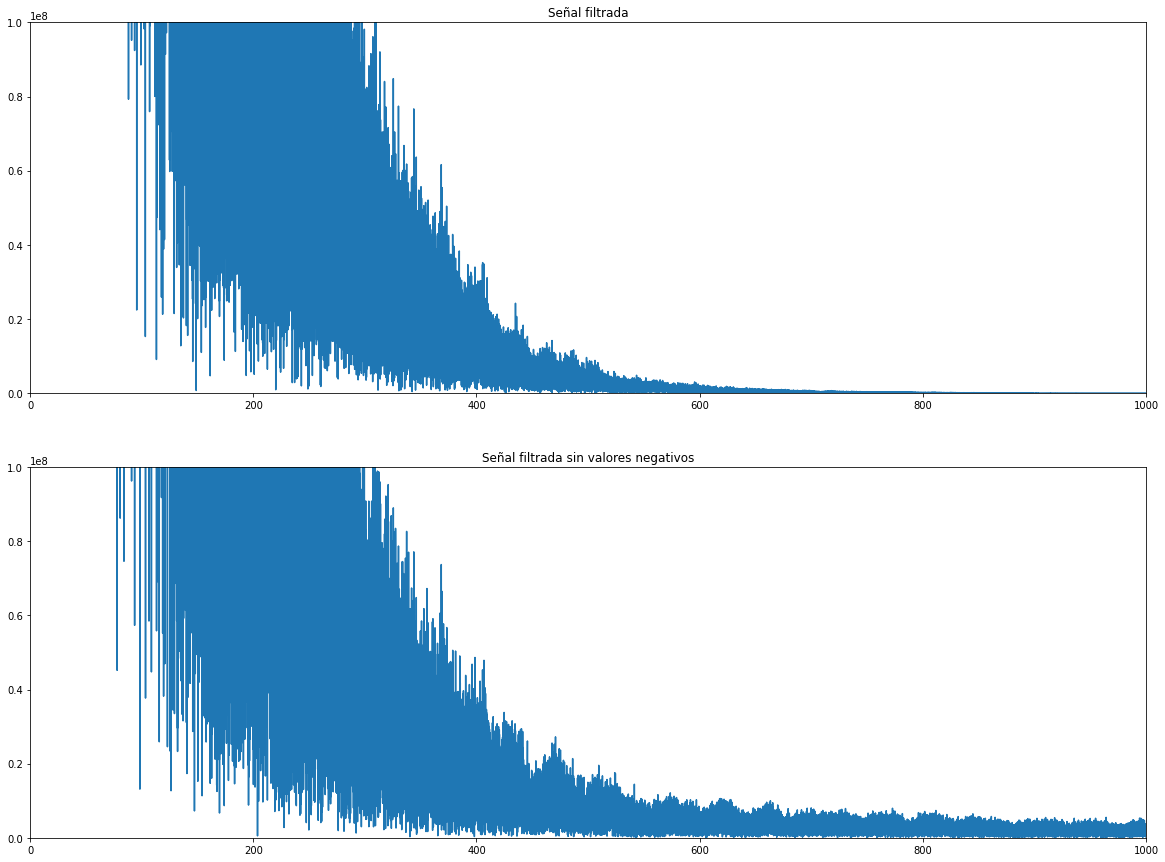

In [15]:
f, axes = plt.subplots(2, figsize=(20, 15))

axes[0].plot(dec_x_freq, filtered_data_fft_2)
axes[0].set_xlim([0, 1000])
axes[0].set_ylim([0, 1e8])
axes[0].set_title("Señal filtrada")

axes[1].plot(dec_x_freq, filtered_data_fft_3)
axes[1].set_xlim([0, 1000])
axes[1].set_ylim([0, 1e8])
axes[1].set_title("Señal filtrada sin valores negativos")

f.show()

Vemos que eliminar los valores negativos agrega componentes en las frecuencias más altas. Sin embaro, estas componentes no aportan mucha energía a la señal. Por lo tanto se considera un trade off aceptable el eliminar los valores negativos a costa de tener más componentes frecuenciales.

Con los valores `b` y `a` podemos implementar el filtro en el micro.

In [16]:
PORT = "/dev/ttyUSB0"
BAUD_RATE = 115200

SAMPLES = 15

serial_port = serial.Serial(PORT, BAUD_RATE, timeout=0.25)
serial_port.flushInput()

results_esp = []
for sample in squared_data[:SAMPLES]:
    data_uint = int(sample)
    serial_port.write(data_uint.to_bytes(4, "little"))
    bytes = serial_port.read(4)
    result = int.from_bytes(bytes, "little")
    results_esp.append(result)

serial_port.close()

Comprobamos que los resultados filtrados en Python y en el micro sean los mismos.

In [17]:
filtered_data_samples = list(filtered_data_3[:SAMPLES].astype(int))
np.array_equal(filtered_data_samples, results_esp)

False

Inspeccionamos los resultados.

In [18]:
filtered_data_samples, results_esp

([0, 0, 3, 19, 59, 127, 219, 331, 458, 607, 798, 1051, 1367, 1733, 2130],
 [0, 0, 3, 7, 15, 8, 22, 0, 45, 0, 153, 0, 444, 0, 1215])

Los resultados arrojados por los algoritmos son distintos. Para comprobar que no sea un error del algoritmo del micro lo implementamos en Python.

In [19]:
WINDOW_SIZE = len(b)
inp = [0 for i in range(WINDOW_SIZE)]
out = [0 for i in range(WINDOW_SIZE)]
x_coef = b
y_coef = a


def filter_sample(sample):
    for i in range(WINDOW_SIZE - 1, 0, -1):  # Se rotan las entradas
        inp[i] = inp[i - 1]

    inp[0] = sample  # La nueva lectura se almacena en la posición 0

    output = inp[0] * x_coef[0]

    for i in range(1, WINDOW_SIZE):  # Se calcula la salida
        output += inp[i] * x_coef[i] - out[i - 1] * y_coef[i - 1]
    for i in range(WINDOW_SIZE - 1, 0, -1):  # Se rotan las salidas
        out[i] = out[i - 1]

    out[0] = int(output if output > 0 else 0)

    return out[0]


[filter_sample(sample) for sample in squared_data[:SAMPLES]]

[0, 0, 3, 7, 15, 8, 22, 0, 45, 0, 153, 0, 444, 0, 1215]

Vemos que los resultados son identicos a los que devuelve el ESP32.
Llegado este punto no estoy seguro si el problema está en mi algoritmo de filtrado, o si es que `signal.lfilter()` realiza un procesamiento diferente que lleva a resultados distintos.

Otra cosa que he notado es que eligiendo una banda de paso muy chica (50 a 70Hz) por ejemplo, los arrays `b` y `a` tienen mas valores y los coeficientes de `b` toman valores muy chicos, cercanos a 0. Esto hace que al utilizar mi algoritmo de fitlrado el resultado se siempre 0. Esto me lleva a pensar que el error puede estar en mi algoritmo.